<a href="https://colab.research.google.com/github/ymuto0302/base1_2021/blob/main/GIS3_4_virtual_market_area_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 仮想的な居住地と商圏から「商圏内に居住する人口」を求める
単純な例を用いて，商圏に居住する人口を数える方法を説明する

---
## (準備) geopandas および rtree のインストール
本ノートブック上で空間結合(spatial join) `sjoin()` を利用するため，rtree が必要となる。

また，geopandas について，Google Colab が標準で提供する geopandas はバージョンの整合が取れていないようだから，**github から最新のソースを持ってくる**。

（参考にしたサイト）  
https://colab.research.google.com/drive/1Kt3vPVIQJUq4QeJ-rE08URpIJEr1g2H3#scrollTo=DT-2i68kvoiN

In [ ]:
!pip install git+git://github.com/geopandas/geopandas.git

  Cloning git://github.com/geopandas/geopandas.git to /tmp/pip-req-build-g51u59rq
  Running command git clone -q git://github.com/geopandas/geopandas.git /tmp/pip-req-build-g51u59rq
     |████████████████████████████████| 15.4 MB 37 kB/s 
     |████████████████████████████████| 6.3 MB 20.2 MB/s 
  Created wheel for geopandas: filename=geopandas-0.10.2-py2.py3-none-any.whl size=1031400 sha256=06a114a07cf89625f94c415de62533ff9f8433440e27ecd798a2875c14cfed62
  Stored in directory: /tmp/pip-ephem-wheel-cache-4il5pfqk/wheels/cf/3e/0b/6475054094c2b1ea054158ac1fdcf749fb92f5b512377e4cf8
Successfully built geopandas


In [ ]:
!apt install python3-rtree 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources
Suggested packages:
  python3-setuptools
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources python3-rtree
0 upgraded, 5 newly installed, 0 to remove and 37 not upgraded.
Need to get 671 kB of archives.
After this operation, 3,948 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-pkg-resources all 39.0.1-2 [98.8 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-dev amd64 1.8.5-5 [285 k

## 居住地域およびその人口の定義
ここではポリゴンを用いて，２つの領域および各領域に住む人口を設定する。

In [ ]:
import geopandas as gpd
from shapely.geometry import Polygon

# 居住地の名称
residents = ["ResidentX", "ResidentY", "ResidentZ"]

# 居住地の設定
cordinates = [[(10, 10), (20, 10), (20, 20), (10, 20)],
              [(25, 25), (30, 25), (30, 30), (25, 30)],
              [(30, 30), (40, 30), (40, 40), (30, 40)]]

# 各地区の人口
pops = [30, 50, 70]

# [[居住地A, 人口A, Polygon-A], [居住地B, 人口B, Polygon-B], ...] の形のリストを作る
data = list()
for resident, cordinate, pop in zip(residents, cordinates, pops):
    data.append([resident, pop, Polygon(cordinate)])

# リストを GeoDataFrame へ変換
pop = gpd.GeoDataFrame(data, columns=['resident', 'population', 'geometry'], crs='EPSG:4612')

# 変数 pop の中身を確認
pop

,resident,population,geometry
0,ResidentX,30,"POLYGON ((10.00000 10.00000, 20.00000 10.00000..."
1,ResidentY,50,"POLYGON ((25.00000 25.00000, 30.00000 25.00000..."
2,ResidentZ,70,"POLYGON ((30.00000 30.00000, 40.00000 30.00000..."


居住地域を可視化する。

ここで人口は反映されない。すなわち，`plot()' が見ているのは geometry のみである。

左下の矩形に 30人，中央の矩形に 50人，右上の矩形に 70人の人口が紐づいている。

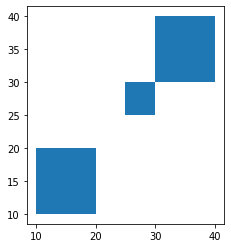

In [ ]:
# 可視化 (確認用)
pop.plot()

## 店舗および商圏の定義
ここでは２つの店舗を考える。
shop A は，上図の左下の矩形内に存在する。また，shop B は右上の区間の左下隅に存在する。

In [ ]:
# 店舗の定義
from shapely.geometry import Point

shopping = gpd.GeoDataFrame([['shopA', Point(15, 15)],
                             ['shopB', Point(30, 30)]],
                            columns=['name', 'geometry'],
                            crs='EPSG:4612')

# 変数の中身を覗き見る
shopping

,name,geometry
0,shopA,POINT (15.00000 15.00000)
1,shopB,POINT (30.00000 30.00000)


店舗を中心とした半径 buffer_size の領域を商圏とする。

次のように buffer() メソッドによりポリゴンを生成できる。

In [ ]:
# ポイント(Point)のバッファをとると，ポリゴンを作ることができる
buffer_size = 10
shopping_areas = shopping.copy() # 'name 列を引き継ぐため，コピーする'
shopping_areas['geometry'] = shopping.buffer(buffer_size)

# 変数の中身を覗き見ると，確かにポリゴンになっている！
shopping_areas

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  after removing the cwd from sys.path.


,name,geometry
0,shopA,"POLYGON ((25.00000 15.00000, 24.95185 14.01983..."
1,shopB,"POLYGON ((40.00000 30.00000, 39.95185 29.01983..."


## 居住地と商圏の可視化
居住地 resident と商圏 shopping_area を可視化し，これらの位置関係を確認する。

居住地を青色，商圏を赤（透明度 0.4）で表現した。

左下では，商圏内に居住地がすっぽり含まれることが分かる。また，右上では，居住地の一部が商圏内に入りきれない状態である。

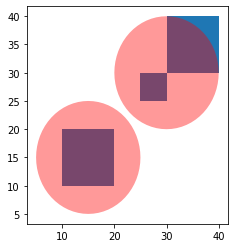

In [ ]:
# 試しに可視化してみる
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1)
pop.plot(ax=ax)
shopping_areas.plot(ax=ax, color='red', alpha=0.4)

## (今回のポイント！）居住地と商圏を空間的に結合した GeoDataFrame の生成
空間結合 (spatial join) とは，２つのポリゴン＝領域の重なったデータを取り出す操作である。
次のように geopandas.sjoin() により実現でき，その文法は以下のとおりである。

    geopandas.sjoin(刺されるデータフレーム，刺すデータフレーム，predicate=操作)
    
predicate に指定できる操作には 'within', 'intersects', 'contatins' 等がある。

In [ ]:
# pop と shopping area の空間的な(spatial)結合
joined = gpd.sjoin(pop, shopping_areas, predicate='within')

この例では操作に 'within' を指定している。
上記の命令は「pop は shopping_areas の内部 (within) か？」という意味であり，
商圏 shipping_areas に完全に含まれる領域およびそこに居住する人口が抽出される。

この例では
- shopA の商圏に含まれる領域は Resident X である。
- shopB の商圏に含まれる領域は Resident Y である。

In [ ]:
# sjoin された結果を表示
joined

,resident,population,geometry,index_right,name
0,ResidentX,30,"POLYGON ((10.00000 10.00000, 20.00000 10.00000...",0,shopA
1,ResidentY,50,"POLYGON ((25.00000 25.00000, 30.00000 25.00000...",1,shopB


空間結合された GeoDataFrame "join" を可視化すると，Resident A および Resident B のみが選択されていることが分かる。

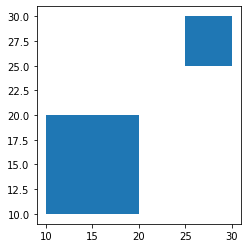

In [ ]:
# 一応，可視化 (Resident A および B のみが表示される）
joined.plot()

### (参考) sjoin の操作(predicate) に within, intersects, contains を指定した場合の挙動

    resident  population  ... index_right   name
0  ResidentX          30  ...           0  shopA
1  ResidentY          50  ...           1  shopB

[2 rows x 5 columns]


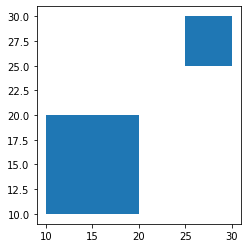

In [ ]:
# resident と shopping area の空間的な(spatial)結合
# predicate = 'within' の場合
joined_within = gpd.sjoin(pop, shopping_areas, predicate='within')
print(joined_within)
joined_within.plot()

    resident  population  ... index_right   name
0  ResidentX          30  ...           0  shopA
1  ResidentY          50  ...           1  shopB
2  ResidentZ          70  ...           1  shopB

[3 rows x 5 columns]


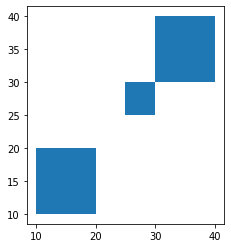

In [ ]:
# resident と shopping area の空間的な(spatial)結合
# predicate = 'intersects' の場合
# intersection (共通部分) ゆえ，少しでも商圏がひっかかれば対象となる
joined_intersects = gpd.sjoin(pop, shopping_areas, predicate='intersects')
print(joined_intersects)
joined_intersects.plot()

In [ ]:
# resident と shopping area の空間的な(spatial)結合
# predicate = 'contains' の場合
# pop のエリアが shopping_area を包含するケースがないため，例外となる
joined_contains = gpd.sjoin(pop, shopping_areas, predicate='contains')
print(joined_contains)
joined_contains.plot()

Empty GeoDataFrame
Columns: [resident, population, geometry, index_right, name]
Index: []


/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:684: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fe626a41830> (for post_execute):


ValueError: ignored

ValueError: ignored

---
# 人口分布の解像度を高めて試してみる
本節では，商圏に含まれる「複数の居住地」に居住する人口の合計を求めることが目的である。

最初に４つの居住地を設定する。コードと可視化した結果を突き合わせれば，意味が分かるだろう。

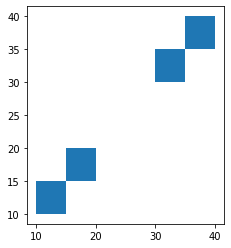

In [ ]:
import geopandas as gpd
from shapely.geometry import Polygon
import fiona
from fiona.crs import from_epsg

# 居住地の名称
residents = ['ResidentW', 'ResidentX', 'ResidentY', 'ResidentZ']

# polygon を作る場合，境界線を結ぶ順番に座標を並べる
cordinates = [[(10, 10), (15, 10), (15, 15), (10, 15)],
              [(15, 15), (20, 15), (20, 20), (15, 20)],
              [(30, 30), (35, 30), (35, 35), (30, 35)],
              [(35, 35), (40, 35), (40, 40), (35, 40)]
             ]

pops = [30, 50, 100, 70]

# [[人口A, Polygon-A], [人口B, Polygon-B], ...] の形のリストを作る
data = list()
for resident, cordinate, pop in zip(residents, cordinates, pops):
    data.append([resident, pop, Polygon(cordinate)])

# GeoDataFrame の生成
pop = gpd.GeoDataFrame(data, columns=['resident', 'population', 'geometry'], crs='EPSG:4612')

# 可視化 (確認用)
pop.plot()

In [ ]:
# 変数 pop の中身を確認
pop

,resident,population,geometry
0,ResidentW,30,"POLYGON ((10.00000 10.00000, 15.00000 10.00000..."
1,ResidentX,50,"POLYGON ((15.00000 15.00000, 20.00000 15.00000..."
2,ResidentY,100,"POLYGON ((30.00000 30.00000, 35.00000 30.00000..."
3,ResidentZ,70,"POLYGON ((35.00000 35.00000, 40.00000 35.00000..."


続けて，２つの店舗を定義し，それぞれの商圏を設定する。

In [ ]:
# 店舗の定義
from shapely.geometry import Point
import fiona
from fiona.crs import from_epsg

shopping = gpd.GeoDataFrame([['shopA', Point(15, 15)],
                             ['shopB', Point(30, 30)]],
                            columns=['name', 'geometry'],
                            crs='EPSG:4612')

In [ ]:
# ポイント(Point)のバッファをとると，ポリゴンを作ることができる
buffer_size = 10 # 10[m]
shopping_areas = shopping.copy() # 'name 列を引き継ぐため，コピーする'
shopping_areas['geometry'] = shopping.buffer(buffer_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  after removing the cwd from sys.path.


In [ ]:
# 変数 shopping_areas の中身を確認
shopping_areas

,name,geometry
0,shopA,"POLYGON ((25.00000 15.00000, 24.95185 14.01983..."
1,shopB,"POLYGON ((40.00000 30.00000, 39.95185 29.01983..."


居住地と商圏の位置関係を可視化した結果を以下に示す。
- 図の左下が "shopA" の商圏，右上が "shopB" の商圏である。
- "shopA" の商圏には２つの居住地が，"shopB" の商圏には１つの居住地が含まれている。

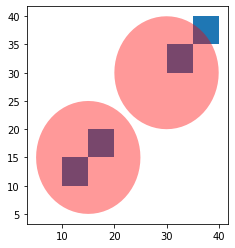

In [ ]:
# 試しに可視化してみる
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1)
pop.plot(ax=ax)
shopping_areas.plot(ax=ax, color='red', alpha=0.4)

空間結合した結果を以下に示す。

"shopA" と２つの居住地 (Resident A と Rsident B) が対応づけられたことが分かるだろう。

In [ ]:
# resident と shopping area の空間的な(spatial)結合
joined = gpd.sjoin(pop, shopping_areas, predicate='within')

In [ ]:
joined

,resident,population,geometry,index_right,name
0,ResidentW,30,"POLYGON ((10.00000 10.00000, 15.00000 10.00000...",0,shopA
1,ResidentX,50,"POLYGON ((15.00000 15.00000, 20.00000 15.00000...",0,shopA
2,ResidentY,100,"POLYGON ((30.00000 30.00000, 35.00000 30.00000...",1,shopB


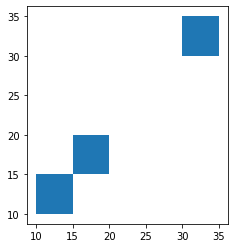

In [ ]:
# 一応，可視化して確かめてみる
joined.plot()

## (今回のポイント！）それぞれの商圏に含まれる人口をカウントする
空間結合されたデータ (変数名 `joined`) を「店舗の名称 (列名 `name`)」でグルーピングする。

下記のとおり，"shopA" と紐付けられたグループには２つのポリゴンが含まれる。

In [ ]:
# (注意) groupby の機能を学生へ説明するためのコード
# ひとつの店舗が複数のポリゴンをカバーすることから，これらをまとめる
for name, group in joined.groupby('name'):
    print(name, group)

shopA     resident  population  ... index_right   name
0  ResidentW          30  ...           0  shopA
1  ResidentX          50  ...           0  shopA

[2 rows x 5 columns]
shopB     resident  population  ... index_right   name
2  ResidentY         100  ...           1  shopB

[1 rows x 5 columns]


グループ内の人口(列名 pop)を合計することで，"shopA", "shopB" の商圏に含まれる人口が得られる。

すなわち，
- "shopA"の商圏：ResidentA (人口 30人) とResidentB (人口 50人)の和
- "shopB"の商圏：RsidentC (人口 100人)のみ

In [ ]:
# ひとつの店舗が複数のポリゴンをカバーすることから，これらをまとめる
for name, group in joined.groupby('name'):
    total = group['population'].sum() # グループ内の合計を得る
    print("{}の商圏人口：{}人".format(name, total))

shopAの商圏人口：80人
shopBの商圏人口：100人


---
### 本ノートブックの内容に関する課題はありません。